## import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

import pickle
import tf_glove
import nltk
import os
import gap
from collections import defaultdict
import seaborn as sns

### Dataset 
    - dbpedia / freebase / wisekb

In [2]:
dataset = 'wisekb'

### File locations

In [3]:
# input : sentence file location
input_sentence_loc = f'../data/{dataset}/property_sentences.txt'

# output : embedding file locations
output_embedding_loc = f'../data/GloVeEntityVectors/glove_{dataset}/embedding_vectors'
output_words_loc = f'../data/GloVeEntityVectors/glove_{dataset}/vector_labels'

# input : train entities locations
train_pos_loc = f'../data/{dataset}/train_positive_20000.txt'

### create stop word list

In [4]:
word_dict = defaultdict(lambda : 0)
sentences = []
with open(input_sentence_loc) as file_:
    for line in file_:
        if line:
            sentences.append(line)
            for word in nltk.wordpunct_tokenize(line):
                word_dict[word] += 1
sorted_dict = sorted(word_dict.items(), key = lambda item: item[1], reverse = True)
stop_word = list(map(lambda x : x[0], sorted_dict[:2])) #stop word threshold
stop_word

['type', 'person_00006026']

### Training GloVe

In [5]:
def read_file(path):
    with open(path) as file_:
        for line in file_:
            if line:
                yield line
                
def sentence_preprocessing(cleaned_sentence, word_index):
    new_sentence = []
    if word_index == 0:
        new_sentence = cleaned_sentence[:word_index+3]
        new_sentence += new_sentence
        new_sentence = new_sentence[1:]
    elif word_index == len(cleaned_sentence)-1:
        if word_index-2 < 0:
            new_sentence = cleaned_sentence
            new_sentence += new_sentence
            new_sentence = new_sentence[:-1]                    
        else:
            new_sentence = cleaned_sentence[word_index-2:]
            new_sentence += new_sentence
            new_sentence = new_sentence[:-1]
    else:
        if word_index < 3:
            new_sentence = cleaned_sentence[:word_index+3]
        else:
            new_sentence = cleaned_sentence[word_index-2:word_index+3]
            
    return new_sentence
    
def tokenize_comment(comment_str, stop_word):
    sentence = nltk.wordpunct_tokenize(comment_str.lower())
    
    cleaned_sentence = []
    for word in sentence:
        if word not in stop_word:
            cleaned_sentence.append(word)
            
    for i, word in enumerate(cleaned_sentence):
        if word.isdigit() and (dataset == 'freebase' or dataset == 'wisekb'):
            new_sentence = sentence_preprocessing(cleaned_sentence, i)
            break
        elif 'e' in word and dataset == 'dbpedia':
            new_sentence = sentence_preprocessing(cleaned_sentence, i)
            break
            
    return new_sentence

def file_corpus(path, stop_word):
    return (tokenize_comment(comment, stop_word) for comment in read_file(path))

corpus = file_corpus(input_sentence_loc, stop_word)

model = tf_glove.GloVeModel(embedding_size=50, context_size=1, min_occurrences=450,
                            learning_rate=0.1, max_vocab_size=10000000, batch_size=512)
model.fit_to_corpus(corpus)
model.train(num_epochs=100, summary_batch_interval=1000)

### Save embedding vectors

In [6]:
em = model.embeddings
f = open(output_embedding_loc,'wb')
pickle.dump(em,f)
f.close()

words = model.words
f = open(output_words_loc,'wb')
pickle.dump(words,f)
f.close()

### Load embedding vectors 
- To check files saved successfully

In [7]:
f = open(output_embedding_loc,'rb')
vector = pickle.load(f, encoding='latin1')
f.close()

f = open(output_words_loc,'rb')
word = pickle.load(f, encoding='latin1')
f.close()
 
glove_dict = {}
for i in range(len(vector)):
    glove_dict[word[i]] = vector[i]
    
print(len(glove_dict))    

50387


### Load train postivie entities

In [8]:
entity_list = []
if dataset=='freebase':
    sep = '\t'
else:
    sep = ' '
with open(train_pos_loc) as f:         
    for i in f:
        entity_list.append(i.split(sep)[0].strip())
        
print('train_pos : ',len(entity_list))
print(entity_list[:5])

train_pos :  20000
['0000172266', '0000277963', '0000259063', '0000008570', '0000346284']


### get optimal K for K-means algorithm 
- get the silhouette score
- use gap statistics

In [9]:
entity_vectors = np.array([glove_dict[n.split()[0].strip()] for n in entity_list])

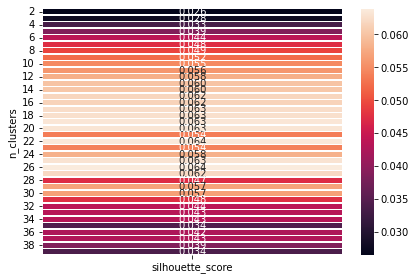

In [10]:
def visualize_silhouette_layer(data, param_init='random', param_n_init=5, param_max_iter=300):
    clusters_range = range(2,40)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()
    plt.close()
    
visualize_silhouette_layer(entity_vectors)

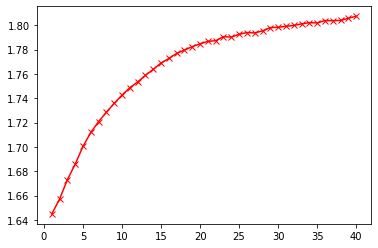

21


In [11]:
gaps, sk, K = gap.gap_statistic(entity_vectors)
plt.plot(K, gaps,'rx-')
plt.show()
opt_k = gap.find_optimal_k(gaps, sk, K)
print(opt_k)